# Continual learning

A small experiment with a convolutional network on MNIST and FashionMNIST datasets. The goal is to train the network on MNIST and then on FashionMNIST. The network should be able to learn both datasets without forgetting the first one. We want to observe the catastrophic forgetting phenomenon. In our case, when performance increase on FashionMNIST, it decreases on MNIST.

In [1]:
import torch
from torch import nn, optim
import torchvision
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

In [2]:
subsample = 10_000
batch_size = 128

In [3]:
# import MNIST
train_data = torchvision.datasets.MNIST(root='./mnist', train=True, transform=torchvision.transforms.ToTensor(), download=True)
test_data = torchvision.datasets.MNIST(root='./mnist', train=False, transform=torchvision.transforms.ToTensor(), download=True)

print(train_data.data.shape)

# sample subsample images
# train_data = torch.utils.data.Subset(train_data, range(subsample))
# test_data = torch.utils.data.Subset(test_data, range(subsample))
mnist_train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
mnist_test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

torch.Size([60000, 28, 28])


In [4]:
# import FashionMNIST
train_data = torchvision.datasets.FashionMNIST(root='./fashion', train=True, transform=torchvision.transforms.ToTensor(), download=True)
test_data = torchvision.datasets.FashionMNIST(root='./fashion', train=False, transform=torchvision.transforms.ToTensor(), download=True)

print(train_data.data.shape)

# sample subsample images
# train_data = torch.utils.data.Subset(train_data, range(subsample))
# test_data = torch.utils.data.Subset(test_data, range(subsample))
fashion_train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
fashion_test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

torch.Size([60000, 28, 28])


In [47]:
class CNN(nn.Module):

    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, 3)
        self.conv2 = nn.Conv2d(16, 32, 3)
        self.max_pool = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(12*12*32, 128)
        self.fc2 = nn.Linear(128, 10)
        self.drop = nn.Dropout(0.5)

    def forward(self, x):
        # convolutions
        x = self.conv1(x)
        x = self.max_pool(self.conv2(x))
        # classifier
        x = x.view(-1, 12*12*32)
        x = torch.relu(self.fc1(x))
        x = self.drop(x)
        return torch.softmax(self.fc2(x), dim=1)

In [48]:
def evaluate_mnist(verbose=1):
    cnn.eval()
    # evaluate on test set and calculate f1 score
    y_pred = torch.empty(0, dtype=torch.long)
    y_test = torch.empty(0, dtype=torch.long)
    for _, (X_batch, y_batch) in enumerate(mnist_test_dataloader):
        output = cnn(X_batch)
        y_pred = torch.cat((y_pred, torch.argmax(output, dim=1)))
        y_test = torch.cat((y_test, y_batch))
    if verbose:
        print("MNIST - F1 score", f1_score(y_test, y_pred, average='macro'))
    return f1_score(y_test, y_pred, average='macro')

In [49]:
def evaluate_fashion(verbose=1):
    cnn.eval()
    # evaluate on test set and calculate f1 score
    y_pred = torch.empty(0, dtype=torch.long)
    y_test = torch.empty(0, dtype=torch.long)
    for _, (X_batch, y_batch) in enumerate(fashion_test_dataloader):
        output = cnn(X_batch)
        y_pred = torch.cat((y_pred, torch.argmax(output, dim=1)))
        y_test = torch.cat((y_test, y_batch))
    if verbose:
        print("Fashion - F1 score", f1_score(y_test, y_pred, average='macro'))
    return f1_score(y_test, y_pred, average='macro')

In [51]:
cnn = CNN()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn.parameters(), lr=1e-3)

mnist_epochs = 15
fashion_epochs = 50
mnist = True
fashion = True

#MNIST
mnist_losses = []
if mnist:
    print("--- MNIST ---")
    cnn.train()
    for epoch in range(mnist_epochs):
        for _, (X_batch, y_batch) in enumerate(mnist_train_dataloader):
            optimizer.zero_grad()
            output = cnn(X_batch)
            loss = criterion(output, y_batch)
            loss.backward()
            optimizer.step()
        mnist_losses.append(loss.item())
        print(f"Epoch {epoch} - loss", loss.item())

    print("--- Scores ---")
    evaluate_fashion()
    evaluate_mnist()

#FashionMNIST
mnist_scores = []
fashion_scores = []
fashion_losses = []
if fashion:
    print("--- FashionMNIST ---")

    cnn.train()
    for epoch in range(fashion_epochs):
        for _, (X_batch, y_batch) in enumerate(fashion_train_dataloader):
            optimizer.zero_grad()
            output = cnn(X_batch)
            loss = criterion(output, y_batch)
            loss.backward()
            optimizer.step()
        # compute mean loss on a batch

        fashion_losses.append(loss.item())
        mnist_scores.append(evaluate_mnist(verbose=0))
        fashion_scores.append(evaluate_fashion(verbose=0))
        print(f"Epoch {epoch} - loss", loss.item())

    print("--- Scores ---")
    evaluate_mnist()
    evaluate_fashion()

--- MNIST ---
Epoch 0 - loss 1.6149742603302002
Epoch 1 - loss 1.7179936170578003
Epoch 2 - loss 1.525158166885376
Epoch 3 - loss 1.4611504077911377
Epoch 4 - loss 1.5865062475204468
Epoch 5 - loss 1.5234363079071045
Epoch 6 - loss 1.4617162942886353
Epoch 7 - loss 1.5248498916625977
Epoch 8 - loss 1.7044748067855835
Epoch 9 - loss 1.5270042419433594
Epoch 10 - loss 1.461150050163269
Epoch 11 - loss 1.4957010746002197
Epoch 12 - loss 1.5236496925354004
Epoch 13 - loss 1.5236718654632568
Epoch 14 - loss 1.5276952981948853
Fashion - F1 score 0.07108624840258095
MNIST - F1 score 0.9533247916606176
--- FashionMNIST ---
Epoch 0 - loss 1.8364205360412598
Epoch 1 - loss 1.8857585191726685
Epoch 2 - loss 1.7111502885818481
Epoch 3 - loss 1.8361471891403198
Epoch 4 - loss 1.8905318975448608
Epoch 5 - loss 1.70724618434906
Epoch 6 - loss 1.7734391689300537
Epoch 7 - loss 1.8360316753387451
Epoch 8 - loss 1.8984633684158325
Epoch 9 - loss 1.8361499309539795
Epoch 10 - loss 1.6486501693725586
Epoc

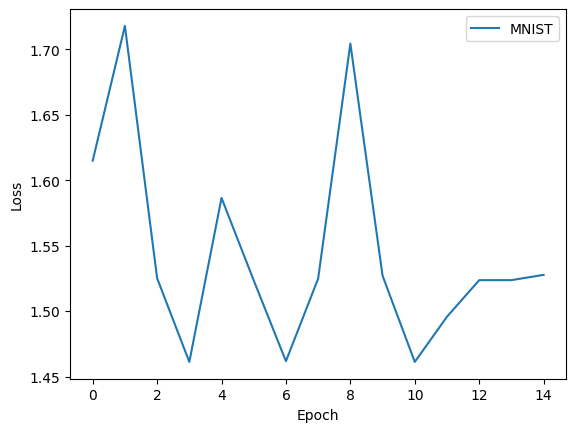

In [52]:
plt.figure()
plt.plot(mnist_losses, label="MNIST")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

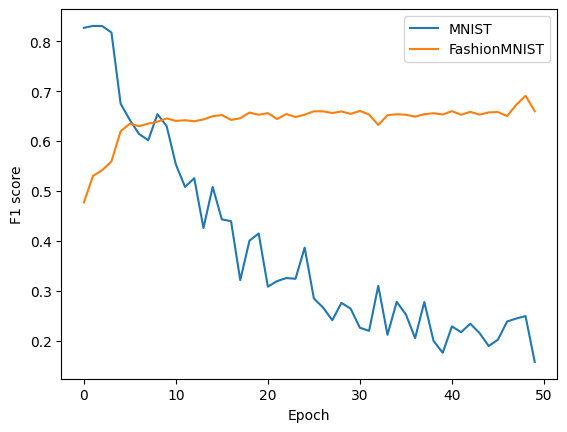

In [53]:
plt.figure()
plt.plot(mnist_scores, label='MNIST')
plt.plot(fashion_scores, label='FashionMNIST')
plt.xlabel('Epoch')
plt.ylabel('F1 score')
plt.legend()
plt.show()